In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from pyqtorch.circuit import QuantumCircuit
from pyqtorch.ansatz import AlternateLayerAnsatz
from pyqtorch.embedding import SingleLayerEncoding
from pyqtorch.operation import Z

## Fit a target function

In [31]:
def target_function(x, degree=3):
    result = 0
    for i in range(degree):
        result += torch.cos(i*x) + torch.sin(i*x)
    return .05 * result

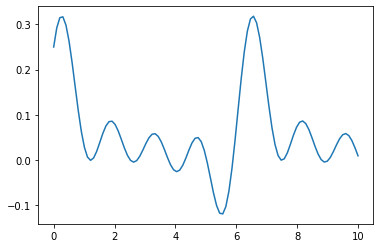

In [32]:
x = torch.tensor(np.linspace(0, 10, 100))
target_y = target_function(x, 5)
plt.plot(x.numpy(), target_y.numpy())

In [33]:
class Model(QuantumCircuit):
    def __init__(self, n_qubits, n_layers):
        super().__init__(n_qubits)
        self.ansatz1 = AlternateLayerAnsatz(n_qubits, n_layers)
        self.embedding = SingleLayerEncoding(n_qubits)
        self.ansatz2 = AlternateLayerAnsatz(n_qubits, n_layers)
        
        
    def forward(self, x):
        batch_size = len(x)
        state = self.init_state(batch_size)
        
        state = self.ansatz1(state)
        state = self.embedding(state, x)
        state = self.ansatz2(state)
        
        new_state = Z(state, [0], self.n_qubits)
        
        state = state.reshape((2**self.n_qubits, batch_size))
        new_state = new_state.reshape((2**self.n_qubits, batch_size))
        
        return torch.real(torch.sum(torch.conj(state) * new_state, axis=0))

In [44]:
n_qubits = 5
n_layers = 3

model = Model(n_qubits, n_layers)

In [35]:
with torch.no_grad():
    y = model(x)

In [38]:
model(x[0:10]).shape

torch.Size([10])

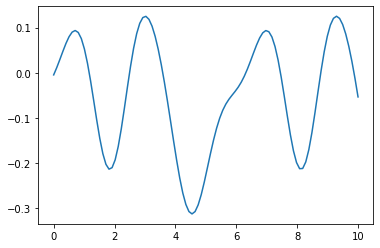

In [39]:
plt.plot(x.numpy(), y.numpy())

In [46]:
y_pred = model(x)
loss = F.mse_loss(target_y, y_pred)
loss.backward()
[param.grad for param in list(model.parameters())]

[tensor([[ 1.8626e-09, -5.3378e-02, -5.2737e-02],
         [-1.8626e-09, -1.8567e-02, -5.0922e-02],
         [ 1.8626e-09, -2.0447e-02, -1.7750e-02],
         [ 1.8626e-09, -5.1735e-02,  4.8328e-02],
         [-1.8626e-09, -1.1384e-02, -3.3668e-02]]),
 tensor([[ 0.0205, -0.0031,  0.0053],
         [ 0.0798,  0.0579,  0.1064],
         [-0.0478,  0.0678, -0.0307],
         [ 0.0348,  0.0525, -0.0331],
         [ 0.0204, -0.0178, -0.0169]]),
 tensor([[ 0.0014, -0.0542, -0.0033],
         [-0.0475,  0.0509,  0.0287],
         [-0.0802,  0.0532, -0.0583],
         [-0.0223,  0.0145,  0.0201],
         [ 0.0758, -0.0095,  0.0501]]),
 tensor([[ 0.0240, -0.0208,  0.0807],
         [ 0.0026, -0.0241,  0.0203],
         [-0.0764, -0.0651,  0.0346],
         [-0.0200, -0.0042, -0.0348],
         [-0.0110,  0.0533,  0.0514]]),
 tensor([[-0.0261, -0.0347,  0.0344],
         [-0.0432, -0.0389,  0.0358],
         [-0.0240, -0.0454,  0.0174],
         [-0.1176, -0.0006,  0.1098],
         [ 0.0282,  

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=.01)
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = F.mse_loss(target_y, y_pred)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1} | Loss {loss}")

Epoch 1 | Loss 0.030377301874139534
Epoch 2 | Loss 0.023949856352446217
Epoch 3 | Loss 0.019662053772590296
Epoch 4 | Loss 0.016338509252434873
Epoch 5 | Loss 0.013396328766450543
Epoch 6 | Loss 0.010759670569066626
Epoch 7 | Loss 0.008547105571518495
Epoch 8 | Loss 0.006840168120941906
Epoch 9 | Loss 0.005602146070576994
Epoch 10 | Loss 0.004698618829850755
Epoch 11 | Loss 0.003992200723049848
Epoch 12 | Loss 0.0034298436814510103
Epoch 13 | Loss 0.003036851859227133
Epoch 14 | Loss 0.002842702561590171
Epoch 15 | Loss 0.0028197844197212856
Epoch 16 | Loss 0.0028838209874125055
Epoch 17 | Loss 0.002941826441491857
Epoch 18 | Loss 0.0029342212004506386
Epoch 19 | Loss 0.002842090216477587
Epoch 20 | Loss 0.0026701772330903406
Epoch 21 | Loss 0.002427697908464943
Epoch 22 | Loss 0.0021221339196448876
Epoch 23 | Loss 0.0017665787847516861
Epoch 24 | Loss 0.0013884974176472306
Epoch 25 | Loss 0.0010276189203994729
Epoch 26 | Loss 0.0007222622393966197
Epoch 27 | Loss 0.0004944469101194976

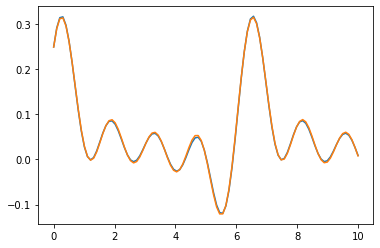

In [41]:
with torch.no_grad():
    y = model(x)

plt.plot(x.numpy(), target_y.numpy())    
plt.plot(x.numpy(), y.numpy())

In [42]:
list(model.children())

[AlternateLayerAnsatz(
   (layers): ModuleList(
     (0): OneLayerEntanglingAnsatz(
       (param_layer): OneLayerRotation()
     )
     (1): OneLayerEntanglingAnsatz(
       (param_layer): OneLayerRotation()
     )
     (2): OneLayerEntanglingAnsatz(
       (param_layer): OneLayerRotation()
     )
   )
 ),
 SingleLayerEncoding(),
 AlternateLayerAnsatz(
   (layers): ModuleList(
     (0): OneLayerEntanglingAnsatz(
       (param_layer): OneLayerRotation()
     )
     (1): OneLayerEntanglingAnsatz(
       (param_layer): OneLayerRotation()
     )
     (2): OneLayerEntanglingAnsatz(
       (param_layer): OneLayerRotation()
     )
   )
 )]

In [43]:
list(model.parameters())

[Parameter containing:
 tensor([[ 3.1180, -0.3559, -5.4875],
         [-3.2656, -2.4510,  2.4562],
         [-3.3324, -4.7461, -0.2470],
         [-1.4906, -3.7808, -5.9494],
         [-3.2107,  0.3757,  3.3626]], requires_grad=True),
 Parameter containing:
 tensor([[-2.2362, -5.7966,  2.3327],
         [ 4.7622, -5.1460,  1.2879],
         [ 0.4236, -2.6969,  0.7510],
         [ 1.8449, -2.8920, -1.4300],
         [-4.5390,  0.9778,  4.9195]], requires_grad=True),
 Parameter containing:
 tensor([[ 2.5670,  1.9446,  0.8757],
         [-0.3643,  2.1091,  5.2814],
         [-4.1296, -4.3088, -2.5476],
         [ 1.6869,  1.3689,  3.4013],
         [-5.2037, -3.3620,  0.2887]], requires_grad=True),
 Parameter containing:
 tensor([[ 4.4715, -4.3855, -1.7593],
         [-3.8258,  6.2452,  2.4033],
         [-5.5640,  1.3960, -0.2407],
         [-4.4565,  3.9509,  2.1412],
         [-4.5824, -4.9877, -6.0066]], requires_grad=True),
 Parameter containing:
 tensor([[-6.0070, -0.3592,  2.8095],